This tutorial demonstrates how to use scSpecies to perform latent alignment of three scRNA-seq datasets from multiple species (mice, humans and hamsters).  

We start by downloading the datasets.

In [ ]:
import os
import muon as mu
#import numpy as np

path = os.path.abspath('').replace('\\', '/')+'/'
mdata = mu.read_h5mu(path+"data/liver_atlas.h5mu")

/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:407: UserWarning: Duplicated obs_names should not be present in different modalities due to the ambiguity that leads to.
  warnings.warn(
/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, whic

Before alignment we plot the unaligned mouse/human dataset pair on the data-level. 
When computation takes too long, we reccomend subsampling the aligned dataset to less than 20000 cells.

/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)



Assingning color to unknown cell type: CD4+ KLRB1 Th

Assingning color to unknown cell type: Circ. NK

Assingning color to unknown cell type: Gamma-Delta T

Assingning color to unknown cell type: Mesothelial Cells

Assingning color to unknown cell type: Mig. DCs

Assingning color to unknown cell type: NK Cells

Assingning color to unknown cell type: NKT Cells

Assingning color to unknown cell type: Pat. Monocytes

Assingning color to unknown cell type: Peritoneal Macs

Assingning color to unknown cell type: Pre-moKCs and moKCs

Assingning color to unknown cell type: RM CD8+ T cells

Assingning color to unknown cell type: Stellate Cells

Assingning color to unknown cell type: Th 1

Assingning color to unknown cell type: Th 17

Assingning color to unknown cell type: Tissue Resident NK

Assingning color to unknown cell type: Trans. Monocytes 2

Assingning color to unknown cell type: cDCs 1

Assingning color to unknown cell type: cDCs 2

Assingning color to unknown cell type: immLAMs

Ass

/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


ValueError: RGBA sequence should have length 3 or 4

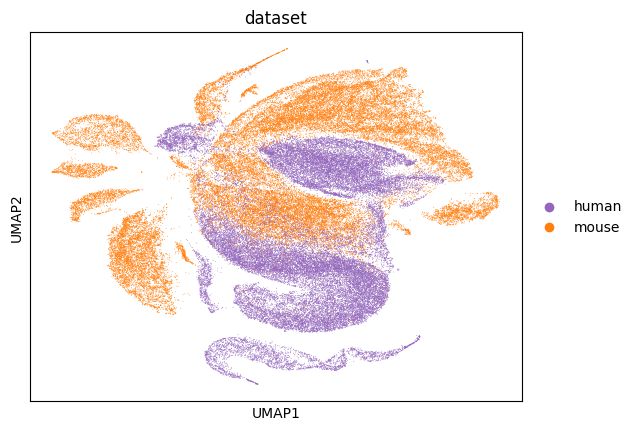

In [2]:
from scipy import sparse
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np

from scSpecies.plot import return_palette

_, hom_ind_mouse, hom_ind_human = np.intersect1d(mdata.mod['mouse'].var_names, mdata.mod['human'].var['var_names_transl'], return_indices=True)
_, _, hom_ind_hamster = np.intersect1d(mdata.mod['mouse'].var_names, mdata.mod['hamster'].var['var_names_transl'], return_indices=True)

adata_concat = ad.AnnData(
    X=sparse.vstack([mdata.mod['mouse'][:, hom_ind_mouse].X, mdata.mod['human'][:, hom_ind_human].X]).toarray(),
    obs=pd.concat([mdata.mod['mouse'].obs, mdata.mod['human'].obs], ignore_index=True)
)

# Color scheme for the liver cell dataset. Won't return nice results for other datasets.
palette = return_palette(list(adata_concat.obs.cell_type_fine.unique()) + list(adata_concat.obs.dataset.unique()))

sc.pp.pca(adata_concat) 
sc.pp.neighbors(adata_concat, use_rep='X_pca') 
sc.tl.umap(adata_concat)

#plot_2D_representation(adata_concat, rep_key='X_umap', plot_annot='cell_type_fine', context_species='mouse', target_species='human')
sc.pl.umap(adata_concat, color=['dataset', 'cell_type_fine'], palette=palette)

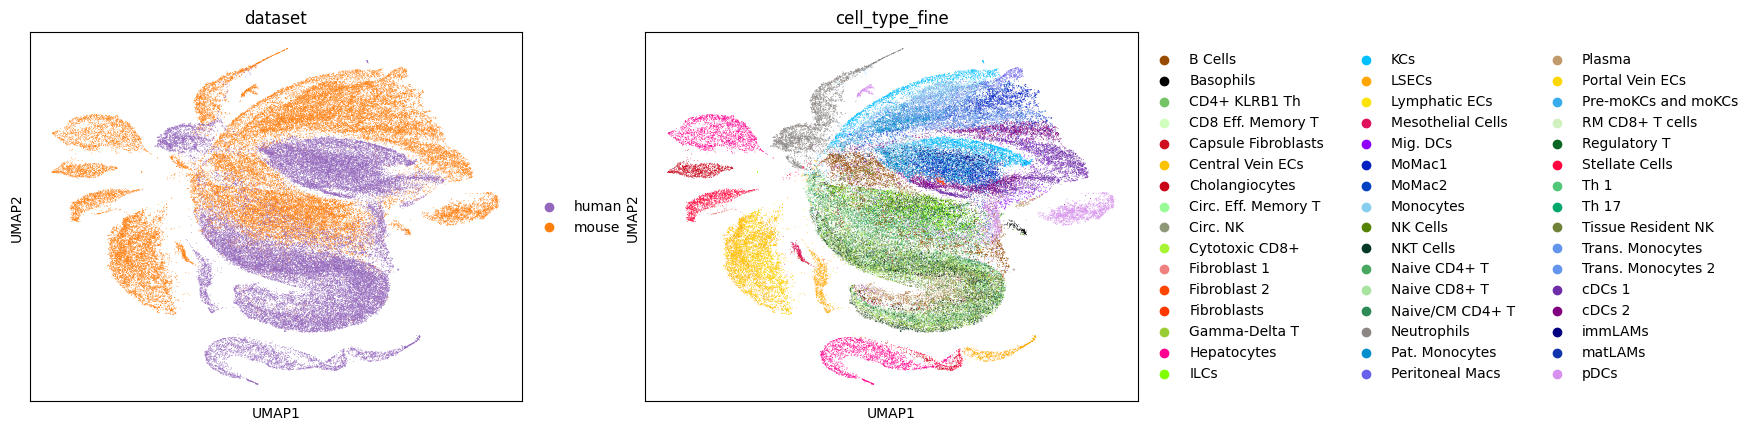

In [4]:
palette = return_palette(list(adata_concat.obs.cell_type_fine.unique()) + list(adata_concat.obs.dataset.unique()))
sc.pl.umap(adata_concat, color=['dataset', 'cell_type_fine'], palette=palette)

## 1) Context and target dataset alignment

Next, we start with mouse and human latent alignment and align the hamster later.

We define the context and target scVI models by instantiating the scSpecies class.   
We recommend using an GPU (NVIDIA or MPS) during training.  
CPU training can be slow, and Apple Silicon runs into errors when trying to compute the log-gamma function for the scVI loss.   

In [6]:
from scSpecies.models import scSpecies
import torch

device = ("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cuda" if torch.cuda.is_available() else "cpu")

model = scSpecies(device, 
                mdata, 
                path,
                context_key = 'mouse', 
                target_key = 'human',          
                alignment = 'inter', 
                )

Initializing context scVI model.
Initializing target scVI model.


We pre-train and evaluate the context scVI model.  
The model parameters are saved to path while latent and intermediate representations are saved in the `muon.MuData` object at the context modality in the `.obsm` layer.

In [ ]:
model.train_context(30, save_key='_mouse')
#model.load(models='context', save_key='_mouse')
model.get_representation(eval_model='context', save_intermediate=True, save_libsize=True)


Pretraining on the context dataset for 30 epochs (= 11730 iterations).
Progress: 99.9% - ETA: 0:00:00 - Epoch: 30 - Iteration: 11721 - ms/Iteration: 20.26 - nELBO: 1480.6 (+1.349) - nlog_likeli: 1462.0 (+1.361) - KL-Div z: 15.416 (-0.020) - KL-Div l: 3.1357 (+0.008).           Saved /Users/cschaech/Desktop/package_test/params/config_dict.pkl
Saved /Users/cschaech/Desktop/package_test/params/context_config__mouse.pkl
Saved /Users/cschaech/Desktop/package_test/params/context_optimizer__mouse.opt
Saved /Users/cschaech/Desktop/package_test/params/target_encoder_inner__mouse.pth.
Saved /Users/cschaech/Desktop/package_test/params/context_encoder_outer__mouse.pth.
Saved /Users/cschaech/Desktop/package_test/params/context_decoder__mouse.pth.
Saved /Users/cschaech/Desktop/package_test/params/context_lib_encoder__mouse.pth.
Calculate latent variables. Step 287/392 

Next we fine-tune by train the target scVI model.

We also track the similarity scores between context and target of prototype cells to monitor the alignment process.  
Monitoring is only possible when target cell type annotation is known.

In [10]:
model.train_target(30, track_prototypes=True, save_key='_human')
#model.load(models='target', save_key='_human')
model.get_representation(eval_model='target', save_libsize=True)

Training on the target dataset for 30 epochs (= 10800 iterations).
Progress: 100.0% - ETA: 0:00:00 - Epoch: 30 - Iteration: 10799 - ms/Iteration: 62.29 - nELBO: 1674.3 (+1.304) - nlog_likeli: 1234.6 (+0.680) - KL-Div z: 13.327 (-0.043) - KL-Div l: 2.5850 (+0.016) - Align-Term: 423.79 (+0.652).           Saved /Users/cschaech/Desktop/package_test/params/config_dict.pkl
Saved /Users/cschaech/Desktop/package_test/params/target_config__human.pkl
Saved /Users/cschaech/Desktop/package_test/params/target_optimizer__human.opt
Saved /Users/cschaech/Desktop/package_test/params/target_encoder_inner__human.pth.
Saved /Users/cschaech/Desktop/package_test/params/target_encoder_outer__human.pth.
Saved /Users/cschaech/Desktop/package_test/params/target_decoder__human.pth.
Saved /Users/cschaech/Desktop/package_test/params/target_lib_encoder__human.pth.
Calculate latent variables. Step 186/361 

After fine-tuning, we can visualize the aligned representation.   

/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


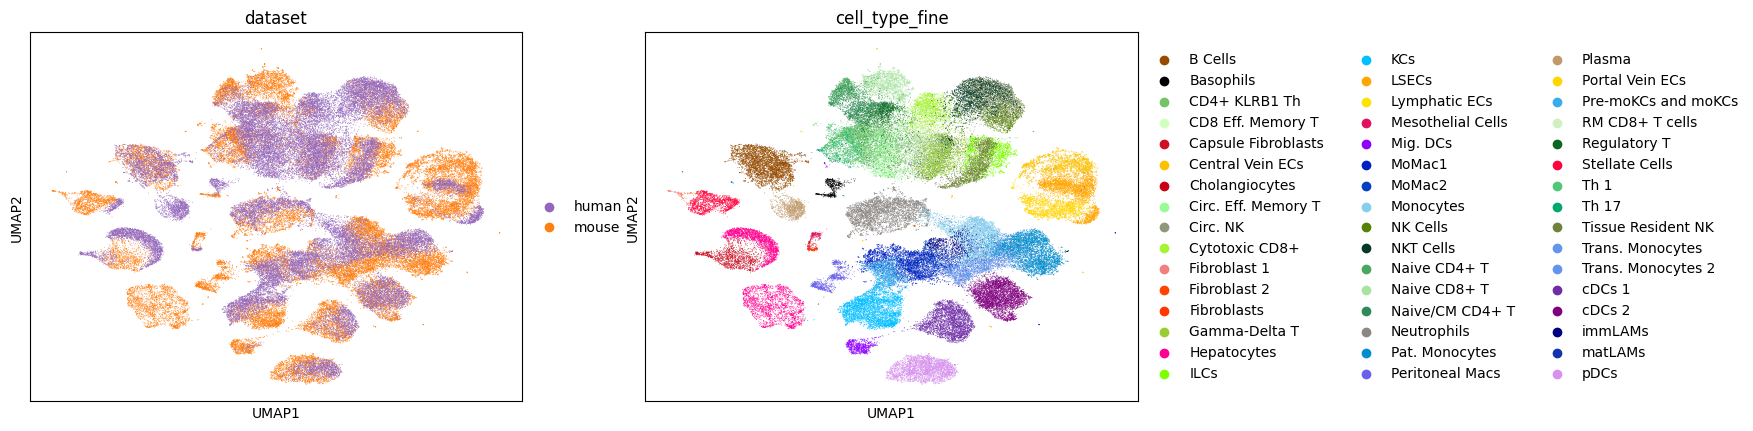

In [11]:
adata_concat.obsm['lat_rep'] = np.concat([mdata.mod['mouse'].obsm['z_mu'], mdata.mod['human'].obsm['z_mu']])

sc.pp.neighbors(adata_concat, use_rep='lat_rep') 
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=['dataset', 'cell_type_fine'], palette=palette)

#plot_2D_representation(adata_concat, rep_key='X_umap_lat_rep', plot_annot='cell_type_fine', context_species='mouse', target_species='human')

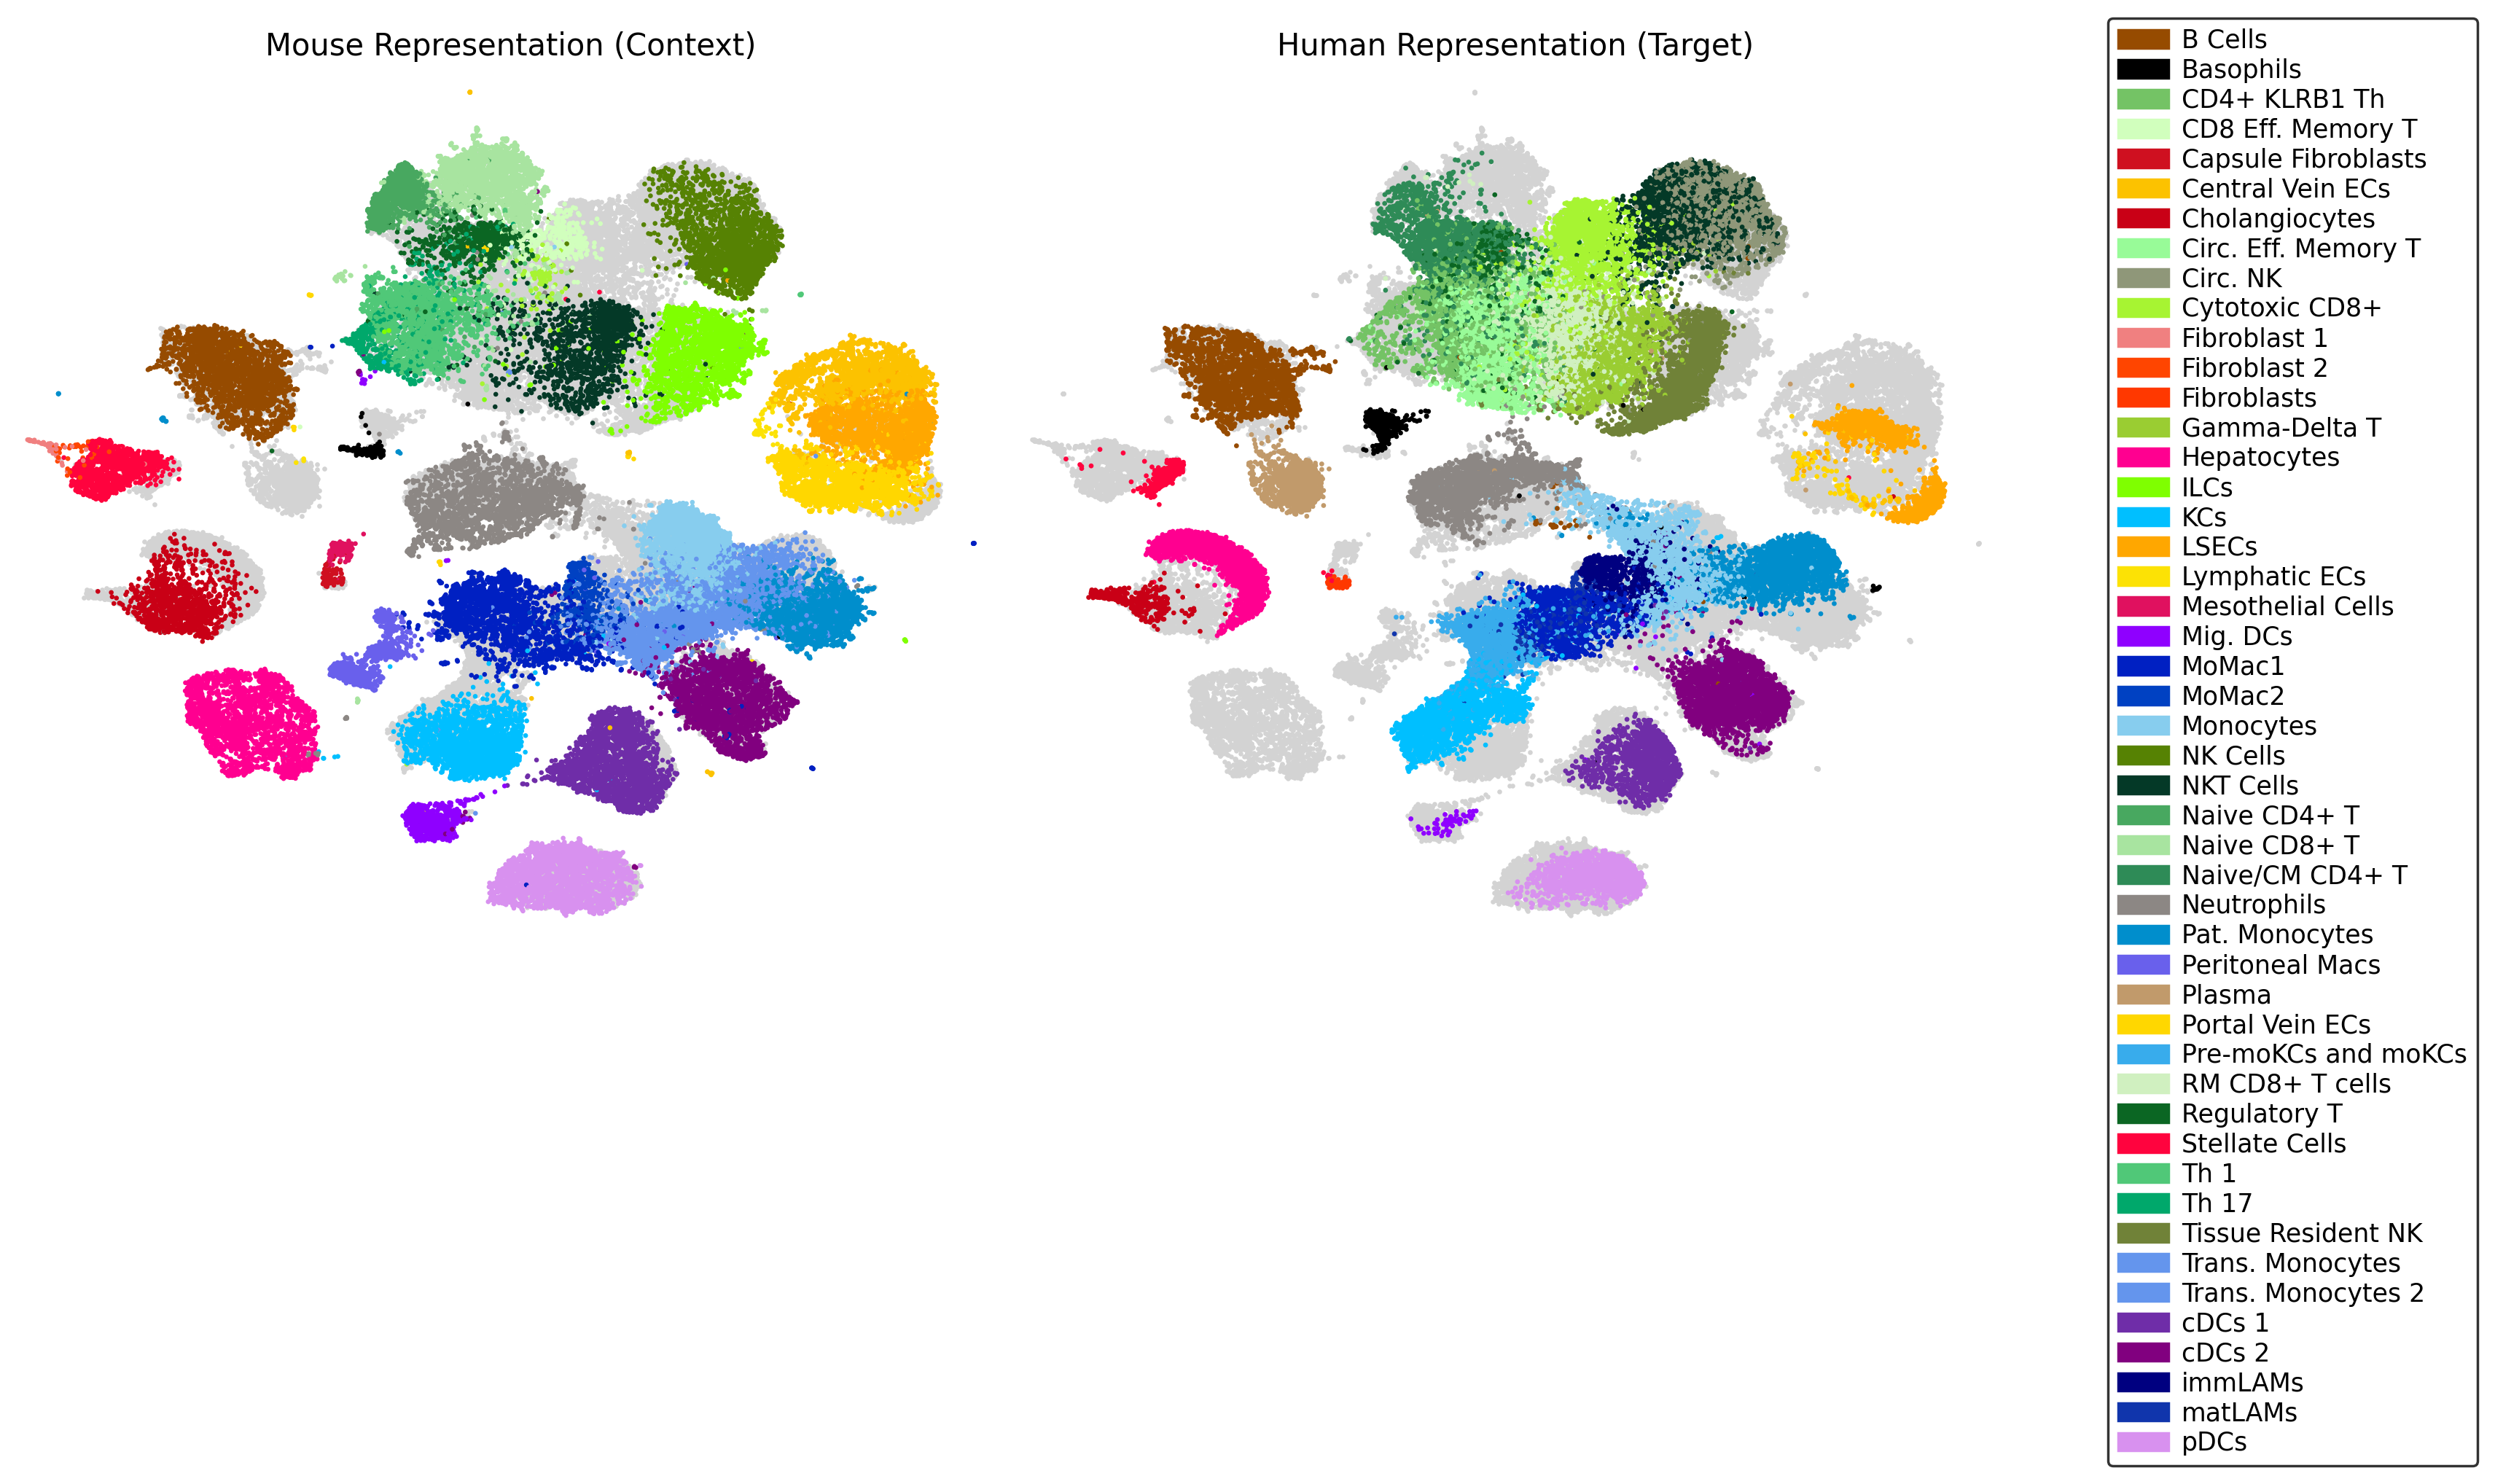

In [12]:
from scSpecies.plot import plot_2D_representation
plot_2D_representation(adata_concat, rep_key='X_umap', plot_annot='cell_type_fine', context_species='mouse', target_species='human')

## 2) Information transfer via similarity scores

Next, we can calculate similarity scores between context and target prototype cells.   
We can use these similarity scores to match cell type annotation between datasets.

/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


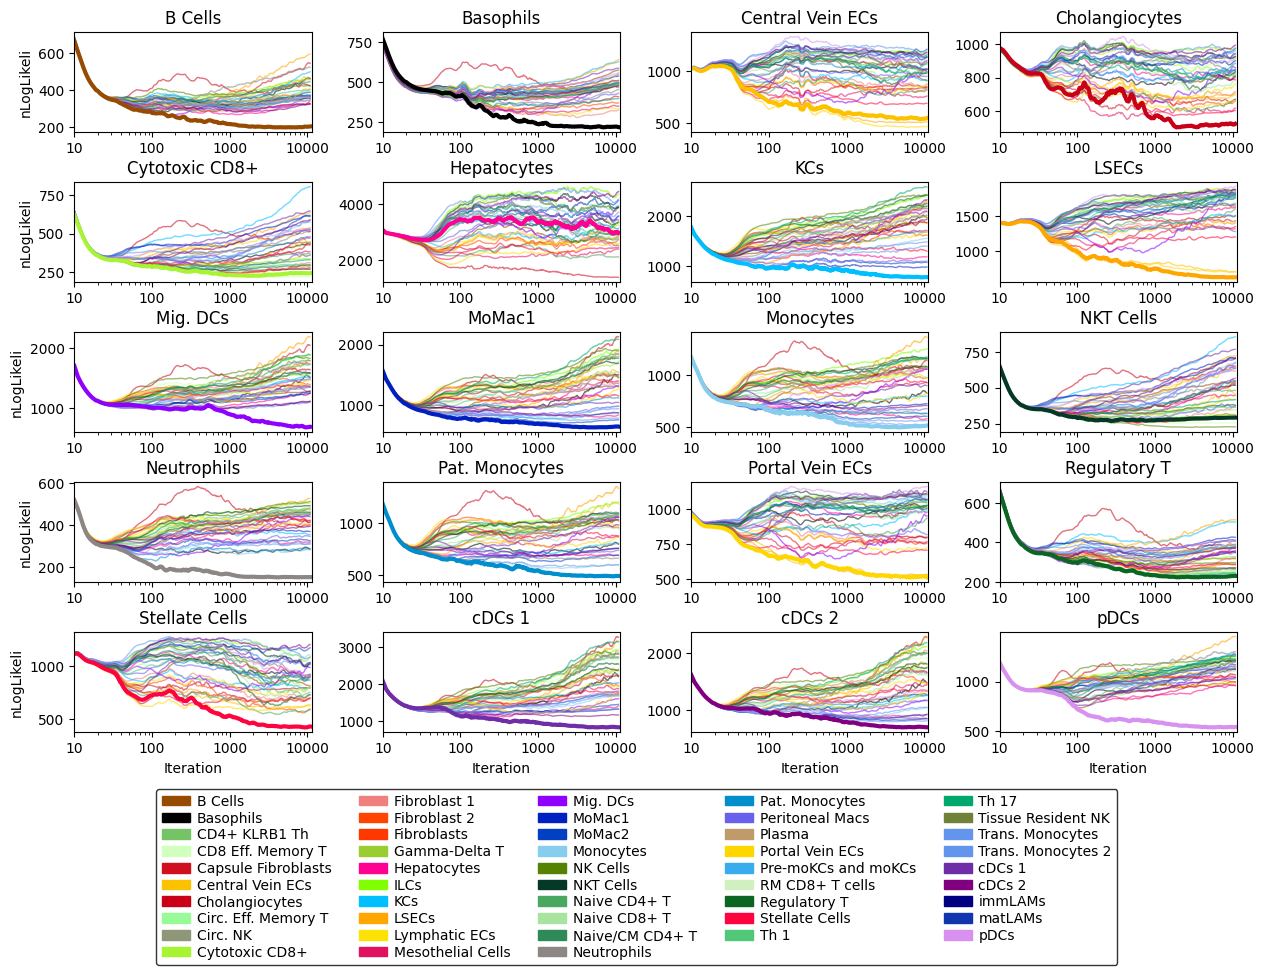

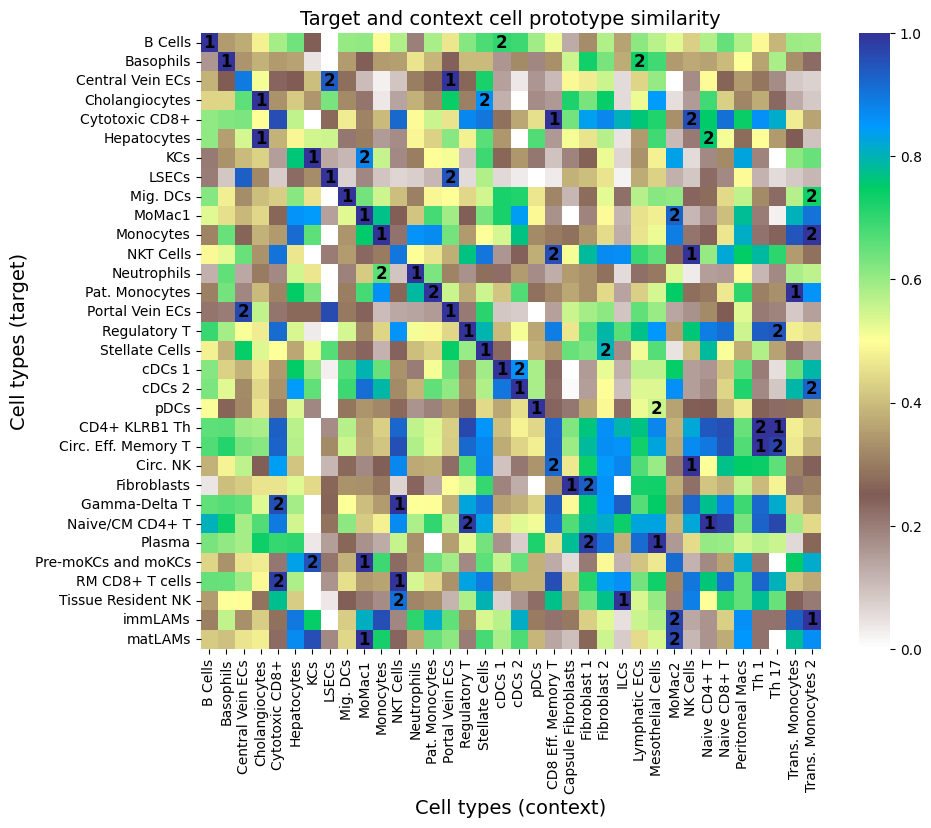

In [14]:
from scSpecies.plot import plot_prototype_sim_history, plot_prototype_sim_heatmap

import matplotlib.pyplot as plt
import seaborn as sns

df = model.return_similarity_df_prot(use_likeli=True, scale='min_max')

plot_prototype_sim_history(model)
plot_prototype_sim_heatmap(df)    

Next, we can calculate similarity scores between context and target cells.   
We use these similarity scores to infer target cell type labels from context cells.

After training, we can predict cell labels using the aligned representation.   
We can compare the quality of the predicted labels with the data level nearest neighbor search.  
The function takes as input a list of tuples of cell label keys that should be compared, in our case coarse and fine cell labels.  
We see that the accuracy is higher for coarse cell labels, which is expected.  

In [ ]:
from scSpecies.plot import plot_similarity

human_labels = model.mdata['human'].obs['cell_type_fine']
mouse_labels = model.mdata['mouse'].obs['cell_type_fine']

common_cell_types = np.intersect1d(human_labels.unique(), mouse_labels.unique())

human_inds = human_labels.isin(common_cell_types).to_numpy().nonzero()[0]
human_ind = np.random.choice(human_inds)

context_obs_transfer = ['cell_type_coarse', 'cell_type_fine']
df_neigbor = model.transfer_info(human_ind, context_obs_transfer)

print('Index of target human cell: {}, Information: {}.'.format(str(human_ind[0]), ', '.join([obs_name+': '+label for label, obs_name in zip(model.mdata['human'].obs[context_obs_transfer].iloc[human_ind].values[0], context_obs_transfer)])))
df_neigbor

Index of target human cell: 35735, Information: cell_type_coarse: cDCs, cell_type_fine: cDCs 2.


cell_type_coarse   cell_type_fine  index  similarity_score
TGTTCCGAGATCCCGC-42             cDCs           cDCs 2  24557         -2.989746
GACTAACGTGCAACGA-46             cDCs           cDCs 2  24535         -0.852295
CTCGTCACATGTCCTC-41             cDCs           cDCs 2  23940          0.385742
TGTGGTAGTGAGGGAG-39             cDCs           cDCs 2  23607          8.091309
CTGATCCCAAGCGTAG-41             cDCs           cDCs 2  24766          8.702637
...                              ...              ...    ...               ...
CAATACGAGTGCAGGT-5      Endothelials  Portal Vein ECs  37533       2426.128418
GTACAGTCATTCTCTA-21     Endothelials            LSECs   8241       2442.315918
AGTCACAAGCATGCGA-16     Endothelials            LSECs   6931       2447.073730
CTAACCCCAGCGTGCT-21     Endothelials            LSECs   7837       2507.633301
TCTACCGGTCAAGCGA-21     Endothelials            LSECs   7715       2514.395020

[50083 rows x 4 columns]

array([2])

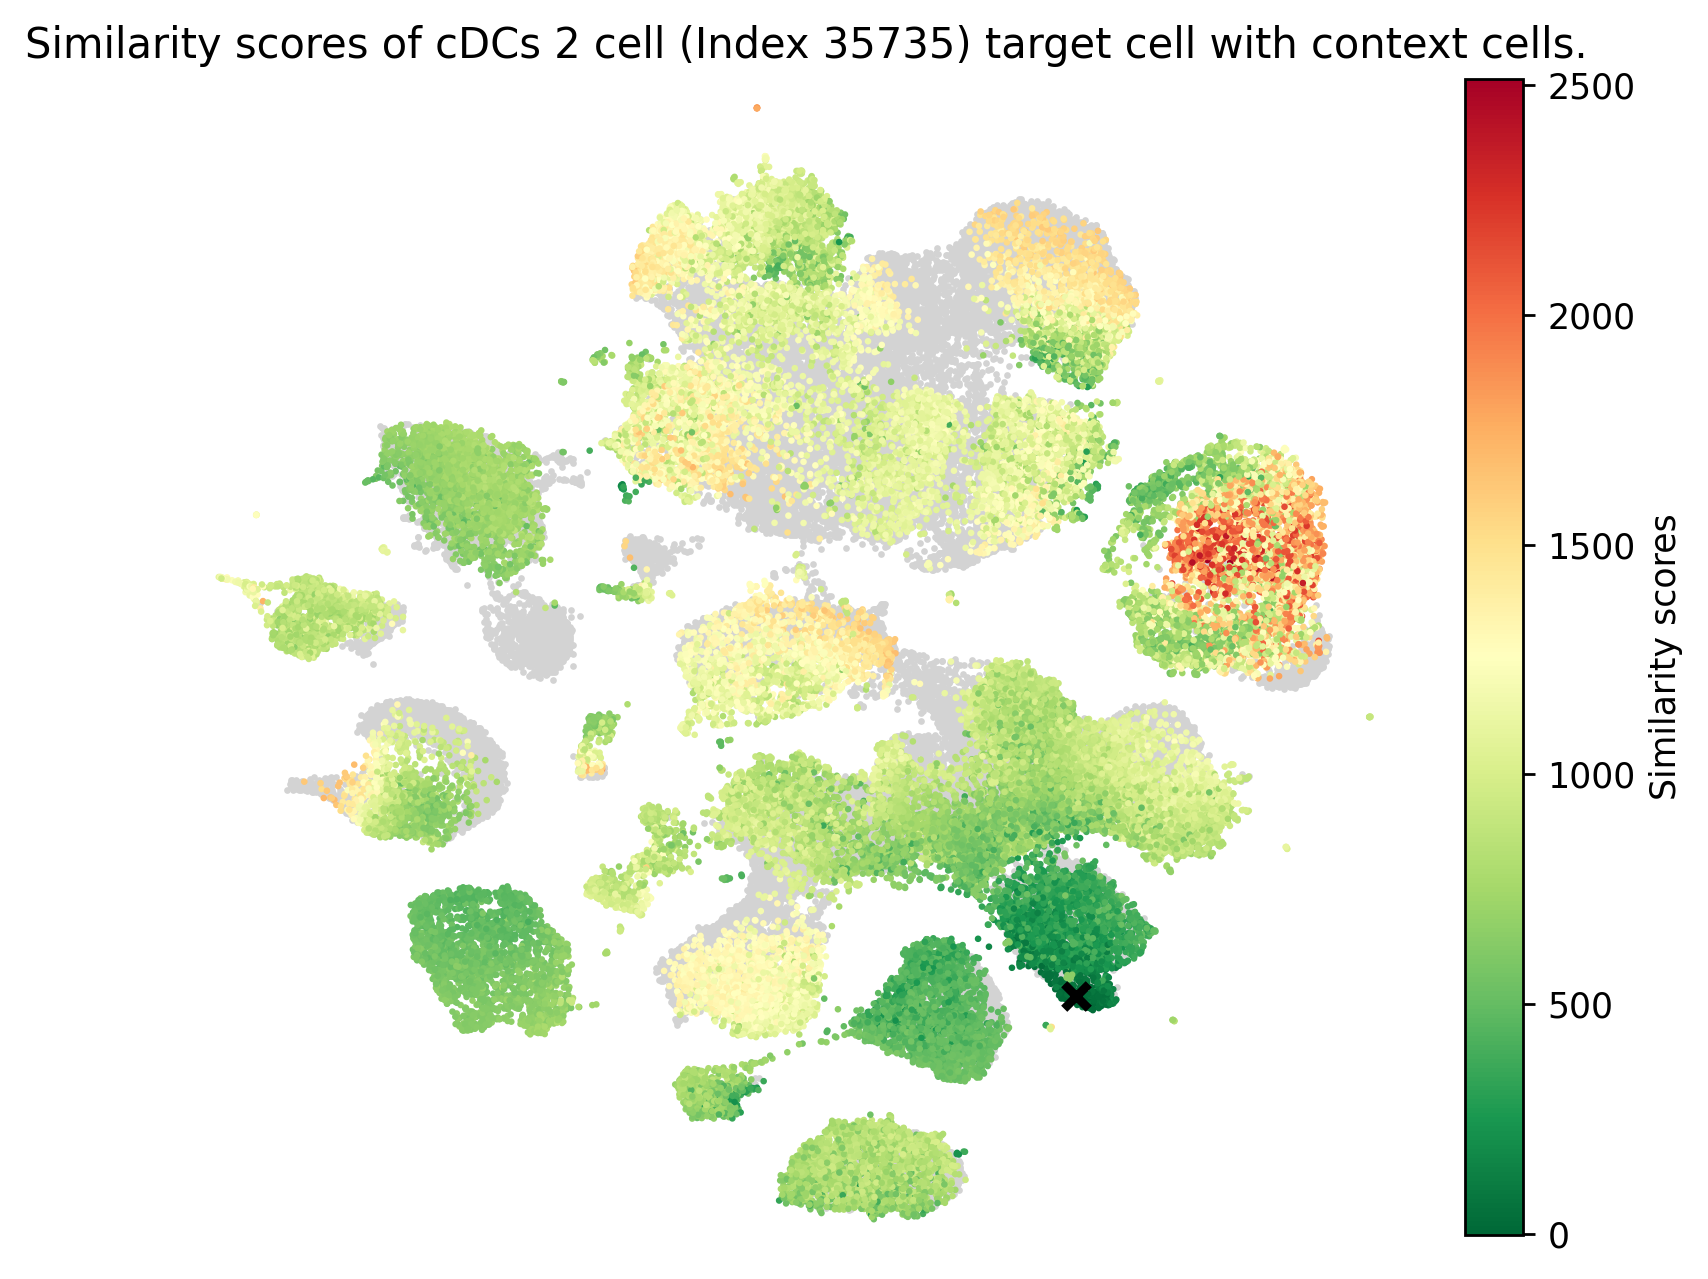

In [16]:
plot_similarity(adata_concat, df_neigbor, human_ind)

In [17]:
model.label_transfer(['cell_type_coarse', 'cell_type_fine'])

Pre-computing latent space NNS with 250 neighbors using the euclidean distance.
Calculate similarity metric. Step 360/361.

In [21]:
model.mdata#[]

MuData object with n_obs × n_vars = 136605 × 10500
  3 modalities
    mouse:	50083 x 4000
      obs:	'cell_type_coarse', 'batch', 'cell_type_fine', 'dataset', 'library_log_mean', 'library_log_std', 'n_genes'
      uns:	'batch_dict', 'metadata'
      obsm:	'batch_label_enc', 'z_mu', 'z_sig', 'inter'
    human:	46159 x 3500
      obs:	'cell_type_coarse', 'batch', 'cell_type_fine', 'dataset', 'library_log_mean', 'library_log_std', 'n_genes', 'top_percent_cell_type_fine', 'pred_nns_cell_type_fine', 'pred_cell_type_coarse_sim', 'pred_cell_type_fine_sim'
      var:	'var_names_transl'
      uns:	'batch_dict', 'metadata'
      obsm:	'batch_label_enc', 'ind_neigh_nns', 'z_mu', 'z_sig', 'l_mu', 'l_sig'
    hamster:	16881 x 3000
      obs:	'cell_type_coarse', 'batch', 'dataset', 'library_log_mean', 'library_log_std', 'n_genes', 'top_percent_cell_type_coarse', 'pred_nns_cell_type_coarse'
      var:	'var_names_transl'
      uns:	'batch_dict', 'metadata'
      obsm:	'batch_label_enc', 'ind_neigh_nns'

In [37]:
from scSpecies.plot import label_transfer_acc

df_nns, bas_nns = model.ret_pred_df(pred_key='pred_nns_cell_type_fine', target_label_key='cell_type_fine', context_label_key='cell_type_fine')
df_sim, bas_sim = model.ret_pred_df(pred_key='pred_sim_cell_type_fine', target_label_key='cell_type_fine', context_label_key='cell_type_fine')


print('Data-level k=25 nearest neighbor search --> Balanced accuracy: {}%'.format(round(bas_nns*100,2)))
print('Label tarnsfer using similarity measure --> Balanced accuracy: {}%'.format(round(bas_sim*100,2)))

label_transfer_acc(df_nns, df_sim)

/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


KeyError: 'pred_sim_cell_type_fine'

We can plot the results with a provided plotting function.  
For other datasets the color palette should be adjusted when a consistent is wanted.  
First we generate bar plots that indicate improvement over the data level NNS for the coarse cell labels:

## 3) Differential gene expression analysis

Finally, the difference in modeled gene expression can be analyzed by comparing the log2-fold change in normalized gene expression.  
The function plots the log2-fold change from context compared to target genes in all shared cell labels on the x-axis.  
On the y-axis are the probabilities of a gene being differentially expressed at level `lfc_delta`

In [ ]:
import pandas as pd

import time


/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/cschaech/Desktop/package_test/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/cschaech/Desktop/package_test/.venv/l

In [ ]:
model.config_dict['device']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [56]:
df_prob_mu

B Cells  Basophils  Central Vein ECs  Cholangiocytes  \
C12orf75  1.000000   0.969325          1.000000        1.000000   
C1orf21   0.952308   0.865031          0.973684        0.684375   
KIAA0040  1.000000   1.000000          0.947368        1.000000   
KIAA0513  0.653333   0.993865          1.000000        0.803125   
C15orf48  0.791282   0.782209          1.000000        0.731250   
...            ...        ...               ...             ...   
ZNF467    0.955385   0.996933          1.000000        1.000000   
ZNF503    0.896410   0.981595          1.000000        0.703125   
ZNF703    0.712821   1.000000          1.000000        0.962500   
ZMYND15   0.678462   0.996933          1.000000        0.987500   
ZYX       0.950256   1.000000          1.000000        1.000000   

          Cytotoxic CD8+  Hepatocytes       KCs     LSECs  Mig. DCs    MoMac1  \
C12orf75        0.999501     0.777551  0.839876  1.000000  1.000000  0.995720   
C1orf21         0.623441     0.998469  0.860021  0.836554  0.859375  0.999287   
KIAA0040        1.000000     0.953571  0.998967  0.933977  1.000000  0.979315   
KIAA0513        0.692768     0.919898  0.999483  1.000000  0.781250  0.708987   
C15orf48        0.672319     0.994898  0.763946  0.999195  0.937500  0.916548   
...                  ...          ...       ...       ...       ...       ...   
ZNF467          0.903741     0.999490  1.000000  0.988728  0.906250  0.901569   
ZNF503          0.849377     0.996429  0.754649  0.995974  0.625000  0.884451   
ZNF703          1.000000     0.954592  1.000000  0.999195  0.734375  0.984308   
ZMYND15         0.938653     0.715816  0.892562  1.000000  1.000000  0.917261   
ZYX             1.000000     0.969898  0.989153  0.913849  0.734375  0.749643   

          Monocytes  NKT Cells  Neutrophils  Pat. Monocytes  Portal Vein ECs  \
C12orf75   0.910079   1.000000     0.998012        0.942211         1.000000   
C1orf21    0.939723   0.631206     0.977634        0.887437         0.918605   
KIAA0040   0.992589   1.000000     0.999503        0.999497         0.941860   
KIAA0513   0.809783   0.864235     0.999503        0.930151         0.988372   
C15orf48   0.771739   0.746201     0.721670        0.748241         0.976744   
...             ...        ...          ...             ...              ...   
ZNF467     0.766304   0.982270     0.654573        0.966332         0.976744   
ZNF503     0.717885   0.995441     0.998012        0.665327         0.883721   
ZNF703     0.749506   1.000000     1.000000        0.634171         0.906977   
ZMYND15    0.794960   0.902229     0.999503        0.662312         1.000000   
ZYX        0.936759   1.000000     1.000000        0.911558         0.976744   

          Regulatory T  Stellate Cells    cDCs 1    cDCs 2      pDCs  
C12orf75      0.865248        0.941379  1.000000  1.000000  1.000000  
C1orf21       0.927305        0.782759  0.704698  0.998473  0.863343  
KIAA0040      1.000000        0.993103  0.902205  1.000000  0.880886  
KIAA0513      0.602837        0.896552  0.622244  0.665140  0.724838  
C15orf48      0.804965        0.696552  0.935762  0.723155  0.629732  
...                ...             ...       ...       ...       ...  
ZNF467        0.992908        1.000000  0.706616  0.685496  0.683287  
ZNF503        0.870567        0.948276  0.962608  0.885496  0.927978  
ZNF703        1.000000        1.000000  0.842761  0.890076  0.830102  
ZMYND15       1.000000        0.965517  0.839885  0.706361  1.000000  
ZYX           1.000000        0.989655  0.778523  0.989822  1.000000  

[1654 rows x 20 columns]

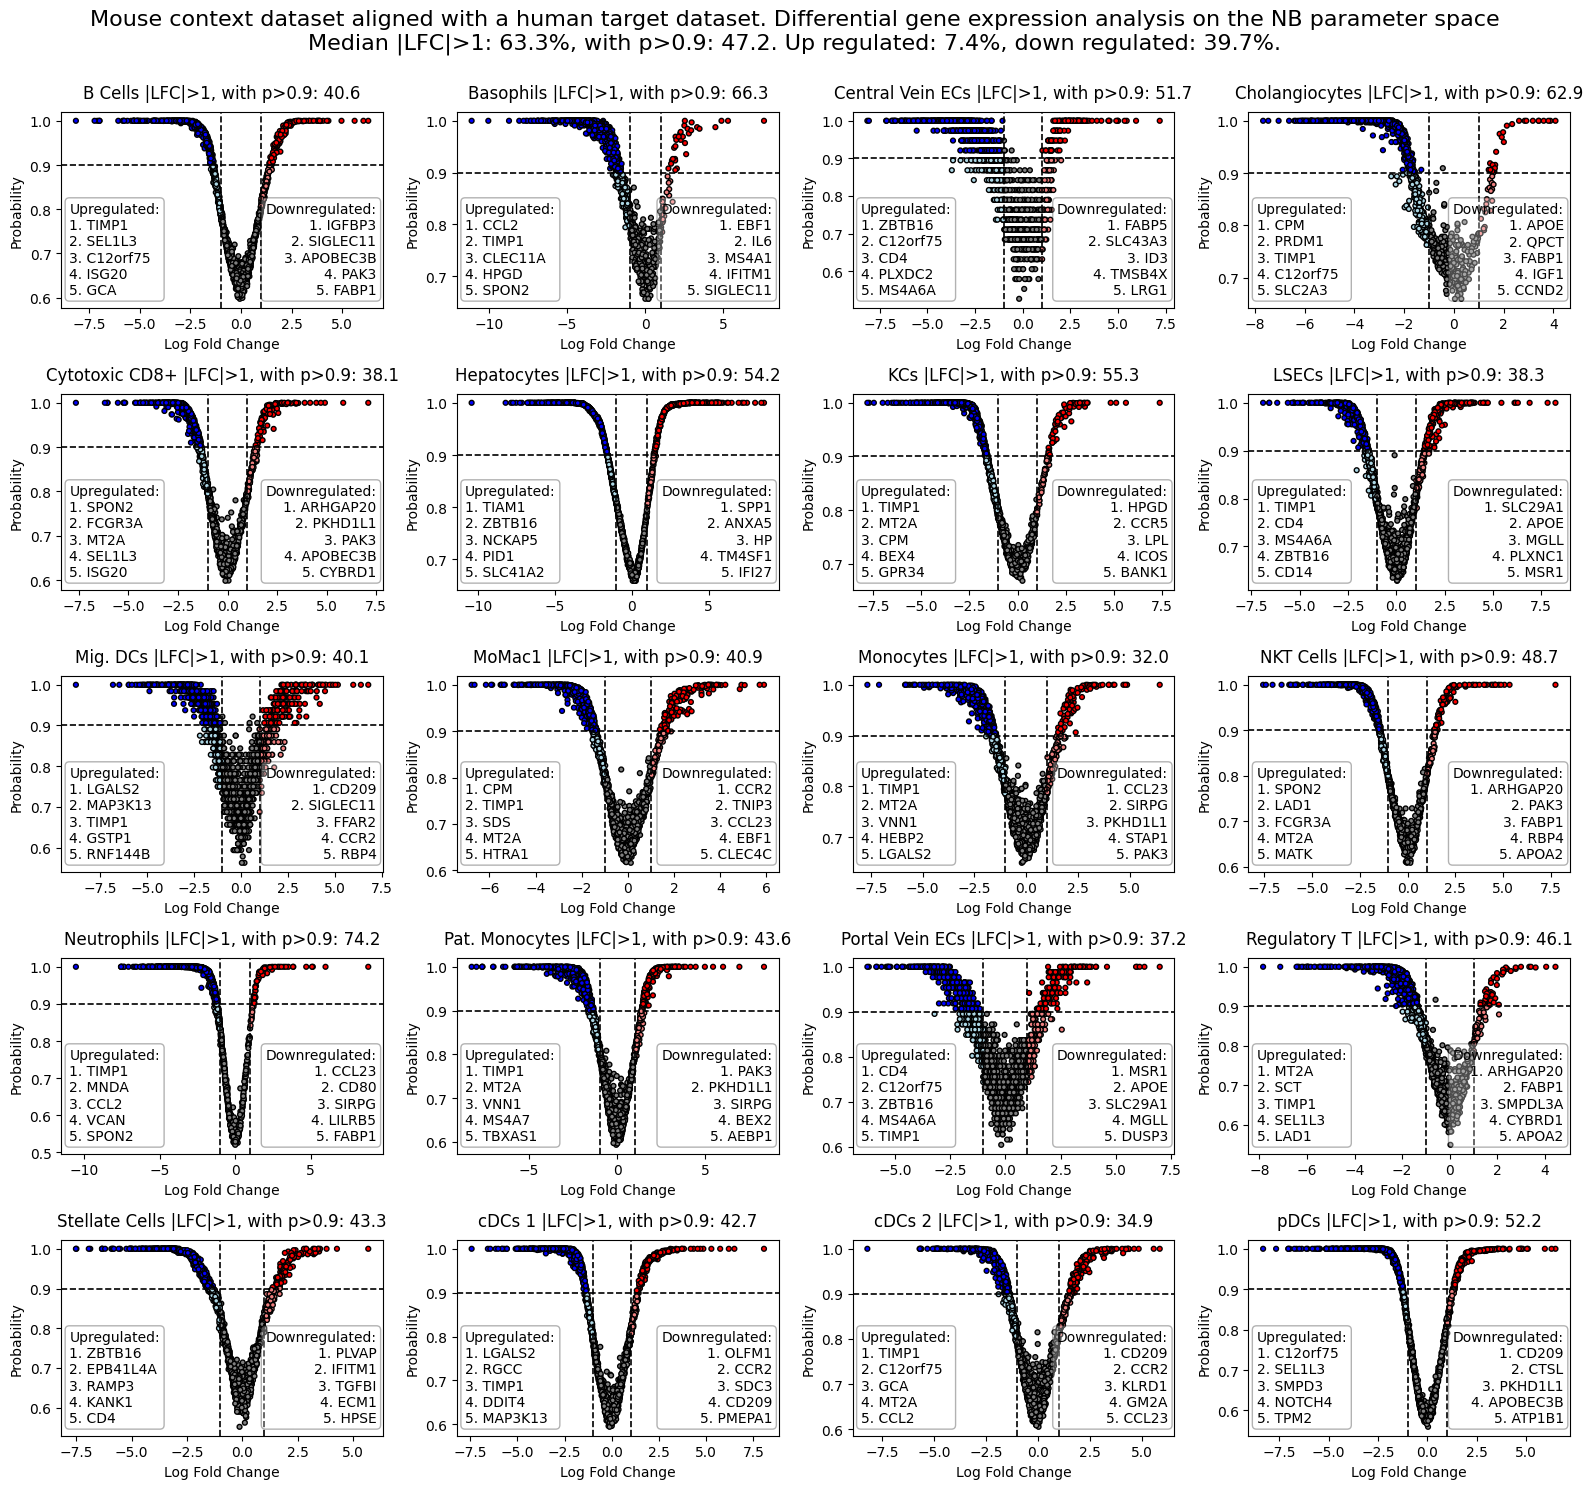

In [57]:
plot_lfc(df_prob_mu, df_lfc_mu, lfc_delta=1, prob_delta=0.9)

In [ ]:
from plot_utils import plot_lfc

model.compute_logfold_change(lfc_delta=1, context_cell_key=context_cell_key, target_cell_key=human_cell_key)
plot_lfc(model, save_path=path, name='human')

All results are written to the `model.mudata` object.  
Let us take a look at how the scPecies workflow has modified the `MuData` object:

![](figures/mdata_after_training.jpg)

In [ ]:
print(model.mdata)

## 4) Creating a cell atlas

Let's train a second scPecies model to align the hamster dataset.  
We instantiate a second model and load the encoder parameters of the context encoder.

If we want to identify differentially expressed genes the context decoder should be retrained.  

In [ ]:
model_hamster = scSpecies(device, 
                mdata, 
                path,
                context_dataset_key = 'mouse', 
                target_dataset_key = 'hamster',                                                   
                )

model_hamster.load(models='context', save_key='_mouse')

model_hamster.train_target(25, save_key='_hamster')
model_hamster.get_representation(eval_model='target')

model_hamster.eval_label_transfer(cell_keys = 'cell_type_coarse')


Again, we can visualize the results.  
We can see for example that the hamster cDCs are aligned with the mice and humans cDC1s, cDC2s and pDCs.  
As the fine hamster labels are unknown can this help us to infer the missing information.

In [ ]:
from plot_utils import plot_umap_three_species

plot_umap_three_species(model, model_hamster, context_cell_key = 'cell_type_coarse', target_cell_key_1 = 'cell_type_coarse', target_cell_key_2 = 'cell_type_coarse', save_path=path)
plot_lfc(model_hamster, save_path=path, name='hamster')